In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import xgboost as xgb

In [3]:
xgb.__version__

'1.1.1'

In [4]:
DATA_DIR_PATH = os.path.join('..', '..', 'data')

def laod_data(file_name):
  file_path = os.path.join(DATA_DIR_PATH, file_name)
  return pd.read_csv(file_path, header=0)

In [5]:
df_train = laod_data('bookmark_train_data.csv')
print(len(df_train))
#df_train.head(3)

199


In [6]:
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
cat_le.fit(df_train['category'])

WORD_CLASSE_LABELS = ['その他', 'フィラー', '副詞', '助動詞', '助詞',
                     '動詞', '名詞', '形容詞', '感動詞', '接続詞',
                     '接頭詞', '記号', '連体詞',]
new_wc_columns = {}
for (i, name) in enumerate(WORD_CLASSE_LABELS):
  new_wc_columns['wc_sum_{}'.format(name)] = 'wc_sum_{}'.format(i)
  new_wc_columns['wc_rate_{}'.format(name)] = 'wc_rate_{}'.format(i)


def data_preprocess(df):
  new_df = df.drop(['ncode', 'title', 'bookmark_cat'], axis=1)

  new_df['category'] = cat_le.transform(new_df['category'])

  new_df['rating'] = new_df['rating'] * 10
  new_df = new_df.astype({'rating': 'int32'})

  #wc_columns = [col for col in new_df.columns if col.find('wc_') != -1]
  #new_df = new_df.drop(wc_columns, axis=1)
  wc_columns = [col for col in new_df.columns if col.find('wc_sum_') != -1]
  new_df = new_df.drop(wc_columns, axis=1)
  new_df = new_df.rename(columns=new_wc_columns)

  kw_columns = [col for col in new_df.columns if col.find('kw_') != -1]
  new_df = new_df.drop(kw_columns, axis=1)

  return new_df

In [7]:
df_train.keys()

Index(['ncode', 'title', 'category', 'bookmark_cat', 'created_at',
       'updated_at', 'char_count_sum', 'new_line_count_sum',
       'talk_char_count_sum', 'new_line_count_rate_sum',
       'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg',
       'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_sum_その他', 'wc_sum_フィラー', 'wc_sum_副詞',
       'wc_sum_助動詞', 'wc_sum_助詞', 'wc_sum_動詞', 'wc_sum_名詞', 'wc_sum_形容詞',
       'wc_sum_感動詞', 'wc_sum_接続詞', 'wc_sum_接頭詞', 'wc_sum_記号', 'wc_sum_連体詞',
       'wc_rate_その他', 'wc_rate_フィラー', 'wc_rate_副詞', 'wc_rate_助動詞',
       'wc_rate_助詞', 'wc_rate_動詞', 'wc_rate_名詞', 'wc_rate_形容詞', 'wc_rate_感動詞',
       'wc_rate_接続詞', 'wc_rate_接頭詞', 'wc_rate_記号', 'wc_rate_連体詞', 'kw_冒険者',
       'kw_魔王', 'kw_日常', 'kw_成り上がり', 'kw_内政', 'kw_恋愛', 'kw_無双', 'kw_青春',
       'kw_ハーレム', 'kw_男主人公', 'kw_奴隷', 'kw_テンプレ', 'kw_勘違い', 'kw_ほのぼの', 'kw_貴族',
       'kw_ギルド', 'kw_コメディ', 'kw_異世界', 'kw_エルフ', 'kw_ファンタジー', 'kw_オリジナル戦記',
       

In [8]:
df_train2 = data_preprocess(df_train)
df_train2.head(3)

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,...,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,0.041585,0.313515,3078.0,128.0,...,0.237664,0.226083,0.225076,0.013595,0.006042,0.007049,0.006042,0.144008,0.011078,30
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,0.053159,0.063559,2596.0,138.0,...,0.238590,0.238013,0.217215,0.017909,0.001155,0.010399,0.001155,0.138070,0.013287,40
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,0.051603,0.170842,1996.0,103.0,...,0.240486,0.177328,0.285020,0.014575,0.000000,0.005668,0.008907,0.148178,0.005668,30


In [14]:
feature_names = df_train2.keys()[:-1]

In [15]:
print(feature_names)
print(len(feature_names))

Index(['category', 'created_at', 'updated_at', 'char_count_sum',
       'new_line_count_sum', 'talk_char_count_sum', 'new_line_count_rate_sum',
       'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg',
       'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_rate_0', 'wc_rate_1', 'wc_rate_2',
       'wc_rate_3', 'wc_rate_4', 'wc_rate_5', 'wc_rate_6', 'wc_rate_7',
       'wc_rate_8', 'wc_rate_9', 'wc_rate_10', 'wc_rate_11', 'wc_rate_12'],
      dtype='object')
26


In [16]:
def filter_outlier(df_input, col):
  mean = df_input.mean()
  sigma = df_input.std() 

  low = mean[col] - 3 * sigma[col]
  high = mean[col] + 3 * sigma[col]

  df_3sigma = df_input[(df_train2[col] > low) & (df_train2[col] < high)]

  return df_3sigma

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
print(df_train2.keys()[3:-1])

Index(['char_count_sum', 'new_line_count_sum', 'talk_char_count_sum',
       'new_line_count_rate_sum', 'talk_char_count_rate_sum', 'char_count_avg',
       'new_line_count_avg', 'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_rate_0', 'wc_rate_1', 'wc_rate_2',
       'wc_rate_3', 'wc_rate_4', 'wc_rate_5', 'wc_rate_6', 'wc_rate_7',
       'wc_rate_8', 'wc_rate_9', 'wc_rate_10', 'wc_rate_11', 'wc_rate_12'],
      dtype='object')


In [23]:
df_train3 = df_train2.copy()

for col in df_train3.keys()[3:-1]:
  df_train3 = filter_outlier(df_train3, col)

In [24]:
df_train3

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,...,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,0.041585,0.313515,3078.0,128.0,...,0.237664,0.226083,0.225076,0.013595,0.006042,0.007049,0.006042,0.144008,0.011078,30
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,0.053159,0.063559,2596.0,138.0,...,0.238590,0.238013,0.217215,0.017909,0.001155,0.010399,0.001155,0.138070,0.013287,40
4,6,1.589543e+09,1.593688e+09,100920,3000,34290,0.029727,0.339774,3364.0,100.0,...,0.264463,0.205307,0.279252,0.015224,0.001305,0.008264,0.001305,0.098304,0.011309,30
6,6,1.572513e+09,1.593421e+09,78840,4620,1410,0.058600,0.017884,2628.0,154.0,...,0.245772,0.245209,0.227170,0.010710,0.001691,0.004510,0.000000,0.114994,0.007328,30
7,6,1.584934e+09,1.593508e+09,51300,1980,3450,0.038596,0.067251,1710.0,66.0,...,0.242481,0.217105,0.250000,0.015977,0.001880,0.008459,0.001880,0.139098,0.004699,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,8,1.421669e+09,1.517615e+09,187440,8130,36720,0.043374,0.195903,6248.0,271.0,...,0.256209,0.204328,0.229162,0.020900,0.006147,0.005164,0.001475,0.146054,0.007131,15
194,6,1.436805e+09,1.574938e+09,122640,5640,8130,0.045988,0.066292,4088.0,188.0,...,0.251648,0.210547,0.269097,0.014734,0.003490,0.006592,0.002714,0.119814,0.009306,10
196,6,1.474528e+09,1.545340e+09,97380,4440,4800,0.045595,0.049291,3246.0,148.0,...,0.246251,0.208515,0.265119,0.015481,0.000000,0.011611,0.001451,0.124819,0.008708,15
197,6,1.470146e+09,1.526466e+09,99570,8070,10650,0.081049,0.106960,3319.0,269.0,...,0.246718,0.204595,0.274070,0.009847,0.002735,0.007112,0.000547,0.142232,0.004376,10


In [25]:
#X = df_train2.drop(['rating'], axis=1).values
#y = df_train2['rating'].values
X = df_train3.drop(['rating'], axis=1).values
y = df_train3['rating'].values

print(X.shape, y.shape)

(151, 26) (151,)


In [26]:
# print(y)

# u, counts = np.unique(y, return_counts=True)
# print(len(u))
# print(u)
# print(counts)

In [27]:
from imblearn.over_sampling import RandomOverSampler

In [28]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

u, counts = np.unique(y_resampled, return_counts=True)
print(len(u))
print(u)
print(counts)

(750, 26) (750,)
15
[ 5 10 15 17 20 25 30 35 40 45 50 52 60 67 75]
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50]


In [29]:
from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, random_state=1)

In [30]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(525, 26) (525,)
(225, 26) (225,)


In [31]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

In [32]:
print(dtrain.feature_names)

['category', 'created_at', 'updated_at', 'char_count_sum', 'new_line_count_sum', 'talk_char_count_sum', 'new_line_count_rate_sum', 'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg', 'talk_char_count_avg', 'new_line_count_rate_avg', 'talk_char_count_rate_avg', 'wc_rate_0', 'wc_rate_1', 'wc_rate_2', 'wc_rate_3', 'wc_rate_4', 'wc_rate_5', 'wc_rate_6', 'wc_rate_7', 'wc_rate_8', 'wc_rate_9', 'wc_rate_10', 'wc_rate_11', 'wc_rate_12']


In [33]:
xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
}

evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,
                early_stopping_rounds=20,
                evals=evals,
                evals_result=evals_result)

[02:06:09] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:30.03583	eval-rmse:29.75313
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:21.85301	eval-rmse:21.68334
[2]	train-rmse:16.18389	eval-rmse:16.32465
[3]	train-rmse:12.19740	eval-rmse:12.79628
[4]	train-rmse:9.09018	eval-rmse:10.16173
[5]	train-rmse:6.96856	eval-rmse:8.64006
[6]	train-rmse:5.33059	eval-rmse:7.79864
[7]	train-rmse:4.31194	eval-rmse:7.42842
[8]	train-rmse:3.45083	eval-rmse:7.07860
[9]	train-rmse:2.88272	eval-rmse:6.90770
[10]	train-rmse:2.53063	eval-rmse:6.82936
[11]	train-rmse:2.09907	eval-rmse:6.76516
[12]	train-rmse:1.86015	eval-rmse:6.65523
[13]	train-rmse:1.47888	eval-rmse:6.55330
[14]	train-rmse:1.20835	eval-rmse:6.42460
[15]	train-rmse:1.05472	eval-rmse:6.38909
[16]	train-rmse:0.93629	eval-rmse:6.3

In [34]:
import math
from sklearn.metrics import mean_squared_error

y_pred = bst.predict(dval)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 6.1452692282488774


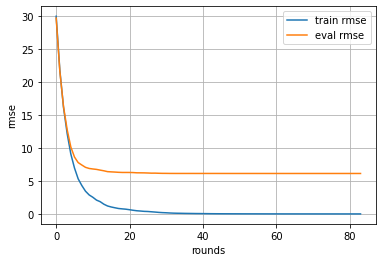

In [35]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')

eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')

plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

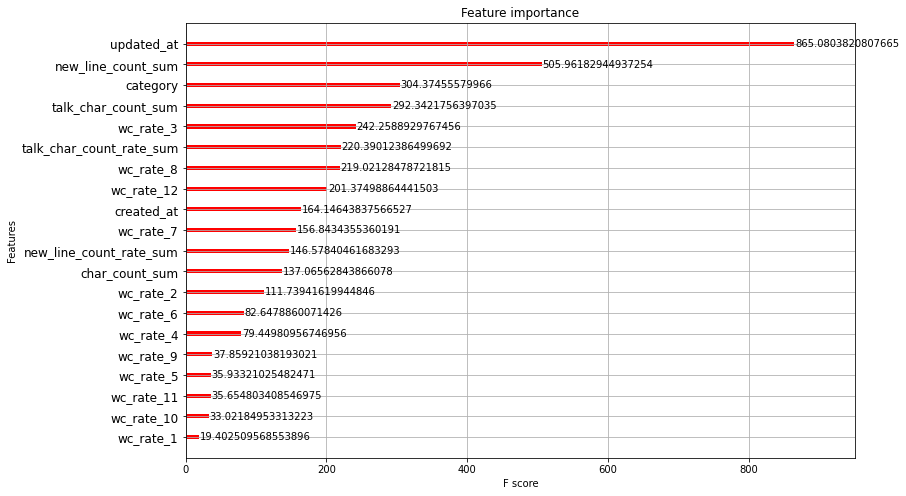

In [36]:
_, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(bst,ax=ax,
                    importance_type='gain',
                    show_values=True,
                    color='red')

plt.yticks(fontsize=12)
#plt.figure(dpi=80)

plt.show()

In [37]:
#xgb.to_graphviz(bst, num_trees=1)

In [38]:
df_test = laod_data('ranking_test_data.csv')
print(len(df_test))
#df_test.head(3)

65


In [39]:
df_test2 = data_preprocess(df_test)
df_test2.head(3)

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,...,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.585469e+09,1.593763e+09,37740,2310,0,0.061208,0.000000,1258.0,77.0,...,0.240634,0.149856,0.386167,0.014409,0.000000,0.000000,0.000000,0.171470,0.001441,-10
1,6,1.591009e+09,1.593774e+09,144330,5760,44100,0.039909,0.305550,4811.0,192.0,...,0.252519,0.217420,0.238219,0.019175,0.002600,0.006175,0.000975,0.132272,0.008450,-10
2,6,1.587737e+09,1.593006e+09,156720,6210,13290,0.039625,0.084801,5224.0,207.0,...,0.248532,0.211128,0.241731,0.011437,0.002473,0.007419,0.001546,0.126739,0.012056,-10


In [40]:
X = df_test2.drop(['rating'], axis=1).values
y = df_test2['rating'].values
print(X.shape)

#dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X, label=y, feature_names=feature_names)
#print(dtest)

(65, 26)


In [41]:
y_pred = bst.predict(dtest)
#y_pred

In [42]:
df_rating = pd.DataFrame(columns=['ncode', 'title', 'rating'])

for i, y in enumerate(y_pred):
    row = df_test.loc[i] 
    #print('{}\t{}\t{}'.format(row.ncode, row.title, y))
    df_rating = df_rating.append({'ncode': row.ncode, 'title': row.title, 'rating': y}, ignore_index=True)

In [43]:
#df_rating.head()

In [44]:
df_rating.describe()

,rating
count,65.000000
mean,27.098251
std,10.864998
min,1.719725
25%,19.784328
50%,28.296804
75%,34.555244
max,67.191559


In [45]:
df_rating.var()

rating    118.04819
dtype: float64

In [46]:
df_rating.median()

rating    28.296804
dtype: float64

In [47]:
pd.set_option('display.max_rows', None)

df_rating.sort_values('rating', ascending=False)

,ncode,title,rating
60,n5645ci,自分が異世界に転移するなら,67.191559
61,n4344dy,世界最強の後衛 ～迷宮国の新人探索者～,43.134911
0,n8642gc,聖貨を集めて、ぶん回せ！,42.195637
11,n1217et,信者ゼロの女神サマと始める異世界攻略 クラスメイト最弱の魔法使い,41.357407
64,n3258fh,クラスメイトに殺された時、僕の復讐は大体達成された,40.276642
30,n1290ff,最強陰陽師の異世界転生記 ～下僕の妖怪どもに比べてモンスターが弱すぎるんだが～,40.187992
50,n5981bn,ニートだけどハロワにいったら異世界につれてかれた,39.938343
10,n1773gf,16年間魔法が使えず落ちこぼれだった俺が、科学者だった前世を思い出して異世界無双,37.709740
44,n9984fb,身体は児童、中身はおっさんの成り上がり冒険記,37.640198
38,n3742ey,ご主人様とゆく異世界サバイバル！,37.638432
